In [8]:
import tifffile as tiff
import os, re
import matplotlib.pyplot as plt

In [3]:
#os.chdir('C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\')

os.chdir('D:\\folders_test\\test_Brovnikov\\')

In [11]:
listdir = os.listdir()


In [13]:
def split_and_sort(value):
    """ 
    Returns the element in the list or array "value" sorted by their numerical order 
    """
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

splits = split_and_sort(listdir[100])

if splits[0] == 'tomo_':
    print('yea')

yea


In [10]:
def showImage(img, string, dpi):
    dim1, dim2 = img.shape
    fig = plt.figure(frameon = False)
    fig.set_size_inches(dim1/dpi, dim2/dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(img, cmap = 'gray')
    plt.colorbar()
    plt.title(string)

In [33]:
import tifffile as tiff
import scipy.constants as constant



energy = 19435.6377/1000
perm_in_vacuum = constant.physical_constants['vacuum mag. permeability']
wlen =  perm_in_vacuum[0] / energy

print(perm_in_vacuum)

distance = 250
delta = 1E-07
beta = 1E-09


(1.25663706212e-06, 'N A^-2', 1.9e-16)


In [109]:
from scipy.signal import medfilt2d
import scipy.constants as constant
import numpy as np
from pyfftw.interfaces.numpy_fft import rfft2, irfft2, fftshift

def Bronnikov(rad, dist, alpha, energy, pixsize):        
    
    
    rad_freq = rfft2(rad - 1) 

    '''from Paganin et al., 2002'''
    perm_in_vacuum = constant.physical_constants['vacuum mag. permeability']
    
    #  lambda
    wlen =  perm_in_vacuum[0] / energy

    # Set the transformed frequencies according to pixelsize:
    rows = rad.shape[0]
    cols = rad.shape[1]
    ulim = np.arange(-(cols) / 2, (cols) / 2)
    ulim = ulim * (2 * np.pi / (cols * pixsize))
    vlim = np.arange(-(rows) / 2, (rows) / 2)
    vlim = vlim * (2 * np.pi / (rows * pixsize))
    u,v = np.meshgrid(ulim, vlim)

    filtre =  (2*np.pi*wlen*dist*(u**2+v**2)) + alpha

    den = fftshift(filtre)
    den = den[:,0:int(den.shape[1] / 2) + 1] 
    
    rad_freq = rad_freq / den

    im = irfft2( rad_freq)

    im = im.astype(np.float32)    

    return im #phase 

def Paganin(rad, dist, delta, beta, energy, pixsize):        
    rad_freq = rfft2(rad) 

    '''from Paganin et al., 2002'''
    perm_in_vacuum = constant.physical_constants['vacuum mag. permeability']
    
    #  lambda
    wlen =  perm_in_vacuum[0] / energy
    mu = 4*np.pi*beta / wlen

    # Set the transformed frequencies according to pixelsize:
    rows = rad.shape[0]
    cols = rad.shape[1]
    ulim = np.arange(-(cols) / 2, (cols) / 2)
    ulim = ulim * (2 * np.pi / (cols * pixsize))
    vlim = np.arange(-(rows) / 2, (rows) / 2)
    vlim = vlim * (2 * np.pi / (rows * pixsize))
    u,v = np.meshgrid(ulim, vlim)

    filtre =  1 + (dist*delta*(u**2+v**2)) / mu

    den = fftshift(filtre)
    den = den[:,0:int(den.shape[1] / 2) + 1] 
    
    rad_freq = rad_freq / den

    im = irfft2( rad_freq)

    im = im.astype(np.float32)
    
    im = -1 / mu * np.log(im)
    return im #phase 

from scipy import ndimage

def Bronnikov_AC(im_phrt, k, dist, energy): #,Rm):      
    perm_in_vacuum = constant.physical_constants['vacuum mag. permeability']
    wlen =  perm_in_vacuum[0] / energy      
    gamma = k*(wlen*dist/(2*np.pi*1))
    print(gamma)
    # gamma = 10
    # print(gamma)
    Corr = 1 - gamma*np.abs(ndimage.laplace(im_phrt))
    return Corr 

In [121]:
im = tiff.imread("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\PROJ1800.tif")
flat  = tiff.imread("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\FLAT0.tif")

im = im/flat
dim = im.shape
fx = dim[0]
fy = dim[1]
energy = 19435.6377/1000
distance = 250
delta = 1E-06
beta = 1E-09
pixsize = 0.002
im_phrt = Paganin(im,distance,delta,beta,energy,pixsize)
#im_phrt = Bronnikov(im,distance,1e-5,energy,pixsize)
im_bronn = Bronnikov_AC(im_phrt, 1, distance, energy)
im_out = im / im_bronn

2.572593747578387e-06


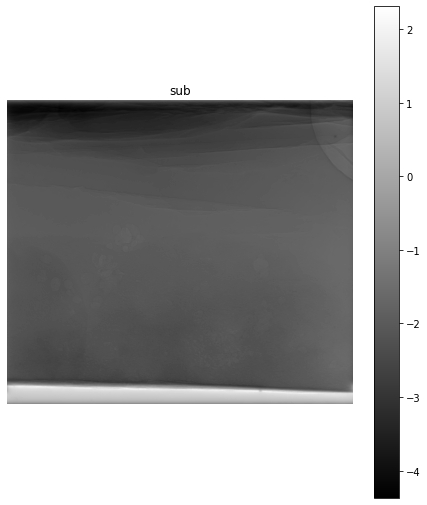

In [122]:
im_2 = im - im_phrt
showImage(im_2, 'sub', 300)
tiff.imsave("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\results\\im_2.tif",im_2)

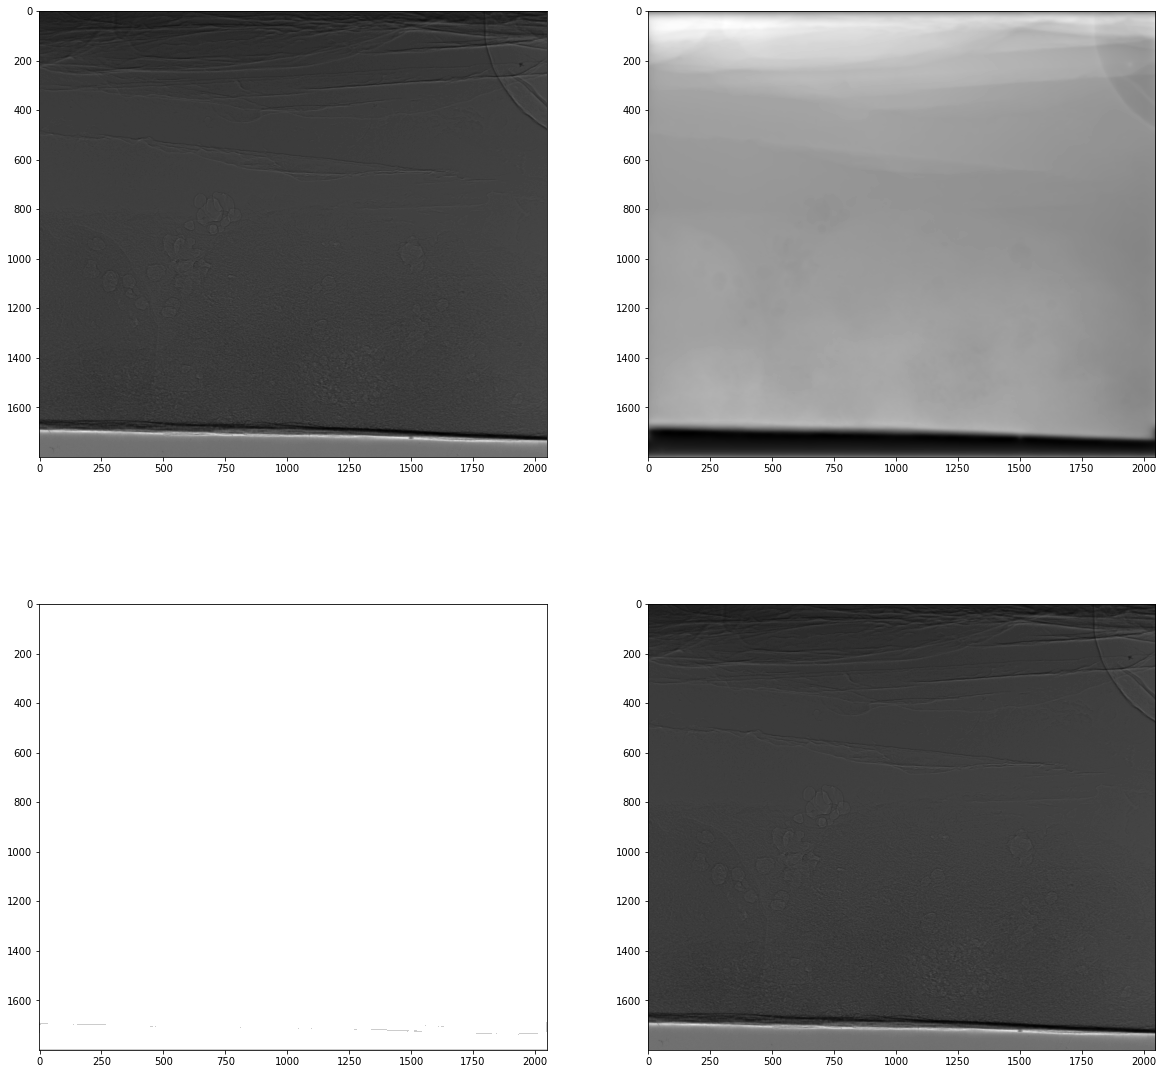

In [123]:
f, axarr = plt.subplots(2,2, figsize=(20, 20));
axarr[0,0].imshow(im, cmap = 'gray') 
axarr[0,1].imshow(im_phrt, cmap = 'gray')
axarr[1,0].imshow(im_bronn, cmap = 'gray')
axarr[1,1].imshow(im_out, cmap = 'gray')
#plt.colorbar()
#showImage(im_phrt, 'paganin', 100)


In [112]:
tiff.imsave("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\results\\im.tif",im)
tiff.imsave("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\results\\im_bronn.tif",im_bronn)
tiff.imsave("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\results\\im_phrt.tif",im_phrt)
tiff.imsave("C:\\Users\\giulia.saccomano\\Documents\\DOTTORATO\\2023-06-bubbleairFilter\\results\\im_out.tif",im_out)